In [3]:
# Paso 1 ‚Äî Cargar el dataset correctamente

import pandas as pd
from pathlib import Path

# Ruta corregida
ruta_dataset = Path("outputs") / "dataset_ready.csv"

# Cargar CSV
df = pd.read_csv(ruta_dataset, encoding="utf-8")

print("‚úÖ Dataset cargado correctamente")
print("Dimensiones:", df.shape)
df.head()




‚úÖ Dataset cargado correctamente
Dimensiones: (290, 58)


Race  Gender  Age (years) Marital status  \
0  Mexican-Mestizo  Female           29        married   
1  Mexican-Mestizo  Female           24        married   
2  Mexican-Mestizo  Female           66          widow   
3  Mexican-Mestizo  Female           29         single   
4  Mexican-Mestizo  Female           40         single   

              Education level Smoking habits  Time of disease (years)  \
0  Incomplete academic degree             No                      4.0   
1  Incomplete academic degree             No                      4.0   
2  Incomplete academic degree             No                     16.0   
3  Incomplete academic degree            yes                      1.0   
4  Incomplete academic degree             No                     13.0   

   HCQ use (mg/day)  SLICC  SLEDAI  ...  Protein intake (g/day)  \
0               NaN    0.0     4.0  ...                  87.005   
1               NaN    0.0     0.0  ...                  87.005   
2               NaN    4.0     0.0  ...                  41.390   
3               NaN    1.0     4.0  ...                  87.005   
4               NaN    1.0     0.0  ...                  87.005   

   Protein intake (%TEI)  Lipid intake (g/day)  Lipid (%TEI)  METs-min/week  \
0                    NaN                 64.62           NaN            NaN   
1                    NaN                 64.62           NaN            NaN   
2                    NaN                 64.62           NaN            NaN   
3                    NaN                 64.62           NaN            NaN   
4                    NaN                 52.70           NaN            NaN   

       IPAQ  FACIT Fatigue Scale  PCS12 (HRQoL)  MCS12 (HRQoL)  Country  
0  Sedentar                  NaN            NaN            NaN   Mexico  
1  Sedentar                  NaN            NaN            NaN   Mexico  
2  Sedentar                  NaN            NaN            NaN   Mexico  
3    Activo                  NaN            NaN            NaN   Mexico  
4  Sedentar                  NaN            NaN            NaN   Mexico  

[5 rows x 58 columns]

# Paso 2 - Filtramos pa√≠ses y eliminamos registros sin SLEDAI

Del dataset cargado, nos centramos en los pa√≠ses con datos de inter√©s (Brazil y Mexico). Eliminamos los registros de Spain y cualquier fila con SLEDAI ausente. Esto asegura que los an√°lisis de correlaci√≥n solo se realicen con datos v√°lidos y comparables.

In [4]:
# Paso 2 ‚Äî Filtrado de datos v√°lidos

# Normalizamos el texto de Country por seguridad (may√∫sculas, espacios)
df["Country"] = (
    df["Country"].astype(str).str.strip().str.replace(r"\s+", " ", regex=True).str.title()
)

# Filtrar solo Brazil y Mexico
df = df[df["Country"].isin(["Brazil", "Mexico"])].copy()

# Eliminar filas sin SLEDAI
df = df[~df["SLEDAI"].isna()].copy()

print("Pa√≠ses presentes tras filtrado:", df["Country"].unique())
print("Dimensiones tras limpieza:", df.shape)


Pa√≠ses presentes tras filtrado: ['Mexico' 'Brazil']
Dimensiones tras limpieza: (213, 58)


# Paso 3 - Selecci√≥n de variables y verificaci√≥n de valores ausentes

Seleccionamos SLEDAI y los biomarcadores (C3, C4, CRP, Vitamina D).
Comprobamos si existen valores nulos en estas variables, tanto de forma global como desglosado por pa√≠s, para tener un panorama de la calidad de datos antes de hacer correlaciones.

In [8]:
# Paso 3 ‚Äî Selecci√≥n de variables y verificaci√≥n de nulos

# Mapeo definitivo de nombres
col_sledai = "SLEDAI"
col_c3 = "C3 complement"
col_c4 = "C4 complement"
col_crp = "C-reactive protein"
col_vitd = "Vitamin D (ng/mL)"

vars_interes = [col_sledai, col_c3, col_c4, col_crp, col_vitd]

# Subconjunto
df_subset = df[["Country"] + vars_interes].copy()

print("Columnas en an√°lisis:", ["Country"] + vars_interes)

# Nulos globales
print("\nNulos globales:")
print(df_subset.isna().sum())

# Nulos por pa√≠s
print("\nNulos por pa√≠s:")
print(
    df_subset.groupby("Country")[vars_interes]
             .apply(lambda x: x.isna().sum())
)



Columnas en an√°lisis: ['Country', 'SLEDAI', 'C3 complement', 'C4 complement', 'C-reactive protein', 'Vitamin D (ng/mL)']

Nulos globales:
Country               0
SLEDAI                0
C3 complement         0
C4 complement         0
C-reactive protein    0
Vitamin D (ng/mL)     0
dtype: int64

Nulos por pa√≠s:
         SLEDAI  C3 complement  C4 complement  C-reactive protein  \
Country                                                             
Brazil        0              0              0                   0   
Mexico        0              0              0                   0   

         Vitamin D (ng/mL)  
Country                     
Brazil                   0  
Mexico                   0  


# Paso 4 -Preparaci√≥n r√°pida de figuras y tipos

In [9]:
# Paso 4 ‚Äî Setup de figuras y tipos

import os
from pathlib import Path
import numpy as np

# 1) Asegurar directorio de salida para figuras
dir_fig = Path("outputs") / "figuras"
dir_fig.mkdir(parents=True, exist_ok=True)
print("Directorio de figuras:", dir_fig.resolve())

# 2) Asegurar tipos num√©ricos en las variables analizadas (por seguridad)
cols_numeric = ["SLEDAI", "C3 complement", "C4 complement", "C-reactive protein", "Vitamin D (ng/mL)"]
for c in cols_numeric:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Confirmaci√≥n r√°pida
print("Tipos dtypes:")
print(df[["Country"] + cols_numeric].dtypes)
print("Registros totales para an√°lisis:", len(df))


Directorio de figuras: C:\Users\manue\TFM M√ÅSTER BIOINFORM√ÅTICA\outputs\figuras
Tipos dtypes:
Country                object
SLEDAI                float64
C3 complement         float64
C4 complement         float64
C-reactive protein    float64
Vitamin D (ng/mL)     float64
dtype: object
Registros totales para an√°lisis: 213


# Paso 5 ‚Äî Scatterplot SLEDAI vs C3 por pa√≠s con l√≠nea de tendencia
Graficamos la relaci√≥n entre SLEDAI y C3 complement diferenciando Brazil/Mexico y a√±adimos la l√≠nea de regresi√≥n (tendencia). Exportamos a outputs/figuras/fig_sledai_vs_c3_by_country.png.n√°lisis:", len(df))


‚úÖ Figura guardada en: C:\Users\manue\TFM M√ÅSTER BIOINFORM√ÅTICA\outputs\figuras\fig_sledai_vs_c3_by_country.png


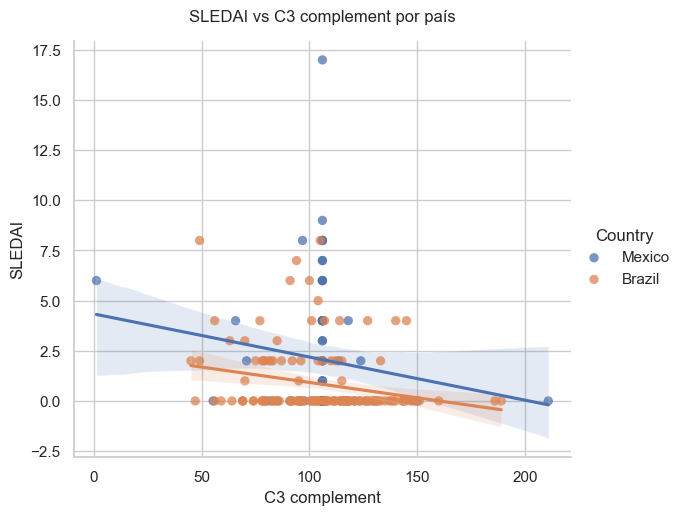

In [10]:
# Paso 6 ‚Äî Scatter SLEDAI vs C3 (por pa√≠s, con l√≠nea de tendencia) y guardar PNG

import seaborn as sns
import matplotlib.pyplot as plt

# Datos
xcol = "C3 complement"
ycol = "SLEDAI"

# Figura
sns.set(context="notebook", style="whitegrid")
g = sns.lmplot(
    data=df, x=xcol, y=ycol, hue="Country",
    scatter_kws={"alpha": 0.75, "s": 45, "edgecolor": "none"},
    height=5, aspect=1.2, ci=95, legend=True
)

# T√≠tulos y ejes
plt.title("SLEDAI vs C3 complement por pa√≠s", pad=14)
g.set_xlabels("C3 complement")
g.set_ylabels("SLEDAI")

# Guardar
out_path = dir_fig / "fig_sledai_vs_c3_by_country.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"‚úÖ Figura guardada en: {out_path.resolve()}")

plt.show()


## Paso extra ‚Äî Boxplot de SLEDAI categorizado vs C3 complement
Dado que SLEDAI es una variable discreta (enteros de 0 a ~20 en la pr√°ctica), muchos valores se concentran en 0‚Äì2.
Para hacerlo m√°s interpretable, se pueden crear categor√≠as cl√≠nicas habituales:

0‚Äì4: Actividad leve o inactiva

5‚Äì9: Actividad moderada

‚â•10: Actividad alta

Con esta clasificaci√≥n, representamos un boxplot de C3 complement en cada grupo de SLEDAI. As√≠ visualizamos si los niveles de C3 cambian significativamente entre categor√≠as de actividad l√∫pica.

C:\Users\manue\anaconda34\Lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
C:\Users\manue\anaconda34\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\manue\anaconda34\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


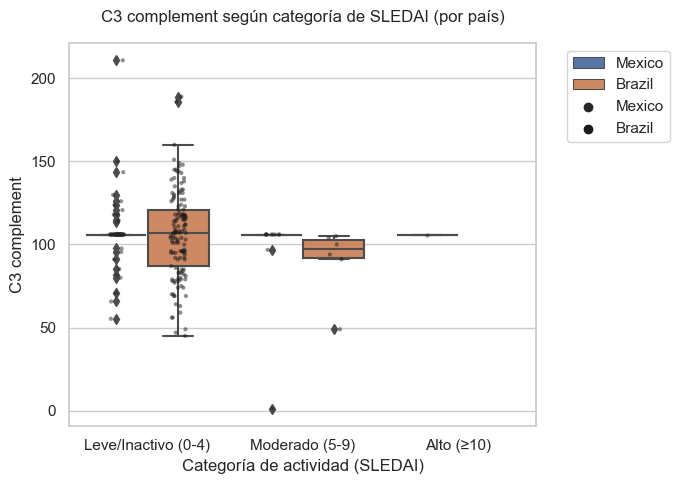

In [11]:
# Paso extra ‚Äî Boxplot SLEDAI categorizado vs C3 complement

# Crear categor√≠as de SLEDAI
def categorizar_sledai(val):
    if val <= 4:
        return "Leve/Inactivo (0-4)"
    elif val <= 9:
        return "Moderado (5-9)"
    else:
        return "Alto (‚â•10)"

df["SLEDAI_cat"] = df["SLEDAI"].apply(categorizar_sledai)

# Figura
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="SLEDAI_cat", y="C3 complement", hue="Country")
sns.stripplot(data=df, x="SLEDAI_cat", y="C3 complement", hue="Country",
              dodge=True, alpha=0.5, jitter=True, size=3, color="k")

plt.title("C3 complement seg√∫n categor√≠a de SLEDAI (por pa√≠s)", pad=15)
plt.xlabel("Categor√≠a de actividad (SLEDAI)")
plt.ylabel("C3 complement")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


# Paso 6 - Scaterrplot SLEDAI vs C4 complement

Representamos la relaci√≥n entre SLEDAI y C4 complement, diferenciando entre Brazil y Mexico mediante color. A√±adimos una l√≠nea de tendencia lineal con intervalo de confianza. Exportamos la figura en outputs/figuras/fig_sledai_vs_c4_by_country.png.

‚úÖ Figura guardada en: C:\Users\manue\TFM M√ÅSTER BIOINFORM√ÅTICA\outputs\figuras\fig_sledai_vs_c4_by_country.png


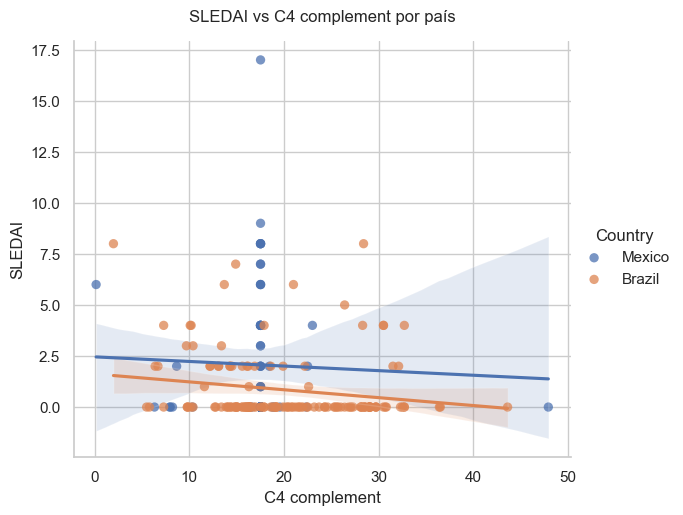

In [12]:
# Paso 6 ‚Äî Scatter SLEDAI vs C4 complement (por pa√≠s)

xcol = "C4 complement"
ycol = "SLEDAI"

sns.set(context="notebook", style="whitegrid")
g = sns.lmplot(
    data=df, x=xcol, y=ycol, hue="Country",
    scatter_kws={"alpha": 0.75, "s": 45, "edgecolor": "none"},
    height=5, aspect=1.2, ci=95, legend=True
)

plt.title("SLEDAI vs C4 complement por pa√≠s", pad=14)
g.set_xlabels("C4 complement")
g.set_ylabels("SLEDAI")

# Guardar PNG
out_path = dir_fig / "fig_sledai_vs_c4_by_country.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"‚úÖ Figura guardada en: {out_path.resolve()}")

plt.show()


# Paso 7 - Scatterplot SLEDAI vs C-reactive protein

Representamos la relaci√≥n entre SLEDAI y C-reactive protein, diferenciando entre Brazil y Mexico por color. A√±adimos la recta de tendencia lineal y su intervalo de confianza. Exportamos la figura a outputs/figuras/fig_sledai_vs_crp_by_country.png.

‚úÖ Figura guardada en: C:\Users\manue\TFM M√ÅSTER BIOINFORM√ÅTICA\outputs\figuras\fig_sledai_vs_crp_by_country.png


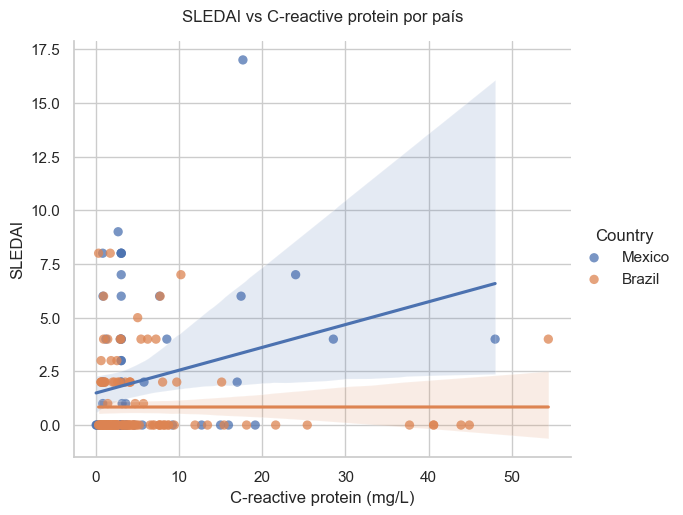

In [13]:
# Paso 7 ‚Äî Scatter SLEDAI vs C-reactive protein (por pa√≠s)

import seaborn as sns
import matplotlib.pyplot as plt

xcol = "C-reactive protein"
ycol = "SLEDAI"

sns.set(context="notebook", style="whitegrid")
g = sns.lmplot(
    data=df, x=xcol, y=ycol, hue="Country",
    scatter_kws={"alpha": 0.75, "s": 45, "edgecolor": "none"},
    height=5, aspect=1.2, ci=95, legend=True
)

plt.title("SLEDAI vs C-reactive protein por pa√≠s", pad=14)
g.set_xlabels("C-reactive protein (mg/L)")
g.set_ylabels("SLEDAI")

# Guardar PNG
out_path = dir_fig / "fig_sledai_vs_crp_by_country.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"‚úÖ Figura guardada en: {out_path.resolve()}")

plt.show()


# Paso 8 ‚Äî Scatterplot SLEDAI vs Vitamin D (por pa√≠s, con l√≠nea de tendencia)
Representamos la relaci√≥n entre SLEDAI y Vitamin D (ng/mL), diferenciando Brazil y Mexico con colores. A√±adimos una l√≠nea de tendencia lineal y el intervalo de confianza. Exportamos la figura en outputs/figuras/fig_sledai_vs_vitd_by_country.png.

‚úÖ Figura guardada en: C:\Users\manue\TFM M√ÅSTER BIOINFORM√ÅTICA\outputs\figuras\fig_sledai_vs_vitd_by_country.png


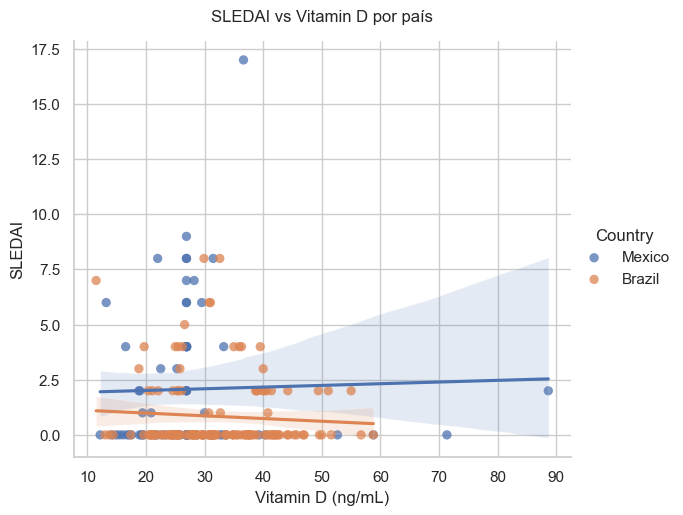

In [14]:
# Paso 9 ‚Äî Scatter SLEDAI vs Vitamin D (por pa√≠s)

xcol = "Vitamin D (ng/mL)"
ycol = "SLEDAI"

sns.set(context="notebook", style="whitegrid")
g = sns.lmplot(
    data=df, x=xcol, y=ycol, hue="Country",
    scatter_kws={"alpha": 0.75, "s": 45, "edgecolor": "none"},
    height=5, aspect=1.2, ci=95, legend=True
)

plt.title("SLEDAI vs Vitamin D por pa√≠s", pad=14)
g.set_xlabels("Vitamin D (ng/mL)")
g.set_ylabels("SLEDAI")

# Guardar PNG
out_path = dir_fig / "fig_sledai_vs_vitd_by_country.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"‚úÖ Figura guardada en: {out_path.resolve()}")

plt.show()


# Paso 9 ‚Äî C√°lculo de correlaciones (Pearson y Spearman)
Calculamos las correlaciones entre SLEDAI y cada biomarcador (C3, C4, CRP, Vitamina D). Lo hacemos de forma global y tambi√©n estratificado por pa√≠s (Brazil y Mexico). Esto nos permitir√° contrastar la tendencia visual de los scatterplots con valores num√©ricos.

In [15]:
# Paso 9 ‚Äî C√°lculo de correlaciones Pearson y Spearman

import scipy.stats as stats

# Variables a correlacionar con SLEDAI
biomarcadores = ["C3 complement", "C4 complement", 
                 "C-reactive protein", "Vitamin D (ng/mL)"]

# Funci√≥n para calcular Pearson y Spearman
def calcular_corr(df, x, y="SLEDAI"):
    pearson_r, pearson_p = stats.pearsonr(df[x], df[y])
    spearman_r, spearman_p = stats.spearmanr(df[x], df[y])
    return pd.Series({
        "Pearson_r": pearson_r, "Pearson_p": pearson_p,
        "Spearman_r": spearman_r, "Spearman_p": spearman_p
    })

# Global
resultados = {}
for biom in biomarcadores:
    resultados[("Global", biom)] = calcular_corr(df, biom)

# Por pa√≠s
for pais in df["Country"].unique():
    df_pais = df[df["Country"] == pais]
    for biom in biomarcadores:
        resultados[(pais, biom)] = calcular_corr(df_pais, biom)

# Convertir a tabla
tabla_corr = pd.DataFrame(resultados).T
tabla_corr.index = pd.MultiIndex.from_tuples(tabla_corr.index, names=["Country", "Biomarker"])

# Mostrar primeras filas
display(tabla_corr.round(3))


Pearson_r  Pearson_p  Spearman_r  Spearman_p
Country Biomarker                                                       
Global  C3 complement          -0.178      0.009      -0.229       0.001
        C4 complement          -0.151      0.028      -0.176       0.010
        C-reactive protein      0.103      0.133       0.083       0.229
        Vitamin D (ng/mL)      -0.065      0.345      -0.045       0.509
Mexico  C3 complement          -0.149      0.218      -0.103       0.398
        C4 complement          -0.036      0.769       0.030       0.805
        C-reactive protein      0.255      0.033       0.158       0.191
        Vitamin D (ng/mL)       0.028      0.815       0.106       0.381
Brazil  C3 complement          -0.237      0.004      -0.291       0.000
        C4 complement          -0.176      0.035      -0.233       0.005
        C-reactive protein      0.000      0.998       0.009       0.919
        Vitamin D (ng/mL)      -0.068      0.421       0.009       0.911

# Exportaci√≥n de la tabla

In [16]:
# Paso 11 ‚Äî Exportaci√≥n de la tabla de correlaciones

# Redondear valores para exportar
tabla_export = tabla_corr.round(3)

# Exportar a CSV
csv_path = dir_fig / "tabla_correlaciones.csv"
tabla_export.to_csv(csv_path)
print(f"‚úÖ Exportado CSV en: {csv_path.resolve()}")

# Exportar a Excel
excel_path = dir_fig / "tabla_correlaciones.xlsx"
tabla_export.to_excel(excel_path)
print(f"‚úÖ Exportado Excel en: {excel_path.resolve()}")


‚úÖ Exportado CSV en: C:\Users\manue\TFM M√ÅSTER BIOINFORM√ÅTICA\outputs\figuras\tabla_correlaciones.csv
‚úÖ Exportado Excel en: C:\Users\manue\TFM M√ÅSTER BIOINFORM√ÅTICA\outputs\figuras\tabla_correlaciones.xlsx


In [18]:
# Filtrar solo Brasil
df_brazil = df[df["Country"] == "Brazil"]

# Resumen estad√≠stico de CRP en Brasil
print("üìä Resumen estad√≠stico de CRP en Brasil:")
print(df_brazil["C-reactive protein"].describe())

# Distribuci√≥n de frecuencias (valores √∫nicos)
print("\nüîé Valores √∫nicos y su frecuencia:")
print(df_brazil["C-reactive protein"].value_counts().sort_index().head(20))  # primeros 20



üìä Resumen estad√≠stico de CRP en Brasil:
count    143.000000
mean       5.359441
std        9.047467
min        0.300000
25%        1.100000
50%        2.300000
75%        4.850000
max       54.400000
Name: C-reactive protein, dtype: float64

üîé Valores √∫nicos y su frecuencia:
C-reactive protein
0.3     3
0.6    10
0.7     4
0.8     2
0.9     6
1.0     8
1.1     4
1.3     1
1.4     7
1.5     1
1.6     5
1.7     4
1.8     2
1.9     1
2.0     4
2.1     2
2.2     4
2.3     4
2.4     3
2.5     2
Name: count, dtype: int64


# 4.2 An√°lisis de correlaciones simples

Con el objetivo de explorar la relaci√≥n entre la actividad cl√≠nica de la enfermedad (SLEDAI) y distintos biomarcadores de inter√©s (C3 complement, C4 complement, C-reactive protein y Vitamina D), se realizaron an√°lisis de correlaci√≥n simples.

En primer lugar, se generaron diagramas de dispersi√≥n entre SLEDAI y cada biomarcador, diferenciando las cohortes de M√©xico y Brasil mediante colores y a√±adiendo l√≠neas de tendencia lineal. Estas representaciones permitieron visualizar posibles patrones de asociaci√≥n.

Los resultados mostraron:

C3 complement: tendencia negativa d√©bil, observada principalmente en la cohorte brasile√±a. Este hallazgo es coherente con el papel del complemento en la actividad l√∫pica, aunque la dispersi√≥n de datos fue amplia.

C4 complement: correlaci√≥n igualmente negativa y d√©bil, significativa en el an√°lisis global y en Brasil, pero no en M√©xico.

C-reactive protein (CRP): se detect√≥ una correlaci√≥n positiva en la cohorte mexicana, mientras que en la brasile√±a no se observ√≥ asociaci√≥n. En Brasil, los valores de CRP se mantuvieron en rangos bajos y con escasa variabilidad (mediana = 2.3 mg/L, 75% < 4.8 mg/L), lo que explica la ausencia de correlaci√≥n con SLEDAI y sugiere que, en esta cohorte bajo dieta antiinflamatoria, la CRP puede no ser un buen marcador de actividad cl√≠nica.

Vitamina D: no se observaron correlaciones significativas con SLEDAI en ninguna de las cohortes, lo que sugiere una relaci√≥n m√°s compleja o modulada por otros factores.

El an√°lisis estad√≠stico confirm√≥ estas observaciones. En el an√°lisis global, tanto C3 como C4 mostraron correlaciones negativas d√©biles pero significativas (Pearson r = ‚Äì0.178 y ‚Äì0.151, respectivamente). En Brasil, las correlaciones fueron m√°s evidentes (C3 r = ‚Äì0.237; C4 r = ‚Äì0.176), mientras que en M√©xico destac√≥ √∫nicamente la correlaci√≥n positiva de CRP con SLEDAI (r = 0.255, p = 0.033). En todos los casos, los coeficientes de Spearman mostraron resultados consistentes, reforzando la robustez de los hallazgos.

En conjunto, estos resultados reflejan asociaciones modestas entre los biomarcadores cl√°sicos y la actividad cl√≠nica medida por SLEDAI, con diferencias seg√∫n la cohorte geogr√°fica y un posible efecto modulador de la dieta antiinflamatoria sobre los niveles de inflamaci√≥n sist√©mica.